## 2023 TBA Predictions

Match data is fetched from TBA by running fetchMatches.py.  Run this first before running this notebook.

`python fetchMatches.py`


In [1]:
from __future__ import print_function
import pickle
#import time
import sys
from collections import Counter
from tqdm import tqdm

sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

# If you fetch_matches best to set reset=True or you may miss some events.
fetch_matches = False
reset = False
year = 2024

if fetch_matches:
    from fetchMatches import fetch_all_matches
    # This will save to matches_{year}.pkl
    fetch_all_matches(year, reset=reset)


In [2]:
# load all the matches

filename = f'matches_{year}.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)

In [3]:
# [m for m in matches['events'] if m.address and 'Spokane' in m.address]
#[m for m in matches['events'] if 'pnc' in m.key]
pnw_district = [m.key for m in matches['events'] if m.district and m.district.abbreviation=='pnw']
pnw_district

['2024orore',
 '2024orsal',
 '2024orwil',
 '2024pncmp',
 '2024waahs',
 '2024wabon',
 '2024wasam',
 '2024wasno',
 '2024wayak']

Filter the matches to completed matches

In [4]:
non_empty = [k for k in matches['matches'].keys() if len(matches['matches'][k])>0]
data = [m for k in matches['matches'] for m in matches['matches'][k]]
data = [m for m in data if m.winning_alliance!='' and m.score_breakdown is not None]
print(f'Found {len(data)} matches')

pnw_teams = set()
for m in [m for m in data if m.event_key in pnw_district]:
    for t in m.alliances.red.team_keys:
        pnw_teams.add(t)
    for t in m.alliances.blue.team_keys:
        pnw_teams.add(t)
    
pnw_teams = list(sorted(pnw_teams))
print(f'PNW Teams: {pnw_teams}')
#red = [x for m in data for x in m.alliances.red.team_keys]
#blue = [x for m in data for x in m.alliances.blue.team_keys]
#from collections import Counter
#Counter(red+blue)

Found 72 matches
PNW Teams: []


In [5]:
pnw_matches = [m for m in data if m.event_key in pnw_district]
pnw_lookup = dict((k,i) for (i,k) in enumerate(pnw_teams))

In [6]:
# We'll only train based on qualifier matches
qualifiers = [x for x in data if x.comp_level=='qm'] 

Create aggregate team statistics for all teams, and a separate set for PNW teams

In [7]:
pnw_matches[0]
def get_rows(m):
    yield m.alliances.red.team_keys, m.score_breakdown['red']['totalPoints']
    yield m.alliances.blue.team_keys, m.score_breakdown['blue']['totalPoints']
list(get_rows(pnw_matches[0]))

[(['frc4061', 'frc2521', 'frc7034'], 78),
 (['frc1540', 'frc3218', 'frc5920'], 93)]

In [8]:
from scipy.sparse import csr_array
from scipy.sparse.linalg import spsolve, norm
import numpy as np

data = []
row = []
col = []
b = []
ctr = 0
for m in map(get_rows, pnw_matches):
    for r in m:
        for t in r[0]:
            row.append(len(b))
            col.append(pnw_lookup[t])
            data.append(1)
        b.append(r[1])
b = np.array(b)            
A = csr_array((data, (row, col)), shape=(len(b), len(pnw_lookup)))
print(A.shape, b.shape )
#x = spsolve(A, b)
#x
from scipy.sparse.linalg import lsqr
from scipy.linalg import lstsq

# Thanks ChatGPT!
x, residuals, rank, s = lstsq(A.todense(), b)

RSS = residuals.sum()
Rinv = np.linalg.inv(np.triu(s))

sigmas = np.sqrt(RSS / (len(b) - len(x)) * np.diag(Rinv))

#return_values = lsqr(A, b, calc_var=True)
#result = return_values
#print(result)
#x = return_values[0]
#var = return_values[-1]
#print(var)

opr = [(t,x[i],sigmas[i]) for i,t in enumerate(pnw_teams)]
for t,opr,sigma in sorted(opr, key=lambda x: x[1], reverse=True):
    print(t,opr,sigma)

#print((A@x).shape,b.shape)
print(A@x-b)
err = np.mean(A@x-b)
print(err)
opr_lookup = dict([(t,(x[i],sigmas[i])) for i,t in enumerate(pnw_teams)])


(1228, 120) (1228,)
frc2910 73.54087141794395 8.660790301338709
frc2046 70.19530204865583 7.96721358431614
frc3663 58.07296390405756 9.126561764385896
frc2521 57.16214707396105 8.247100685678484
frc7461 54.14379738852128 9.99379960823078
frc1318 52.70807018320647 6.937011852445486
frc3636 51.59218315235331 9.105392158380836
frc7627 50.622700698854985 10.03918684806478
frc2990 50.21464837812056 8.88718995444077
frc2930 48.04226369178589 8.787948276201156
frc1425 47.309365523404324 7.502199941842821
frc2471 44.769268393362694 8.225384976118152
frc492 44.18276118487496 9.655648384916086
frc4131 43.33913211563045 9.395901407562713
frc360 43.26621665137262 9.084299126581154
frc2811 42.3744184467147 8.505579651938241
frc2147 41.45023891910231 8.064248685153684
frc955 41.044200057207455 10.399595790289423
frc3218 40.55888776838224 8.969350757275729
frc488 40.238616669216654 9.59719893158457
frc2412 40.01999509673112 8.149160903532175
frc7034 39.87488726667617 9.982367689216062
frc1540 39.0673

Next steps: for a given event we want to decide how to prioritize alliance choices.  Suppose we have all the data to date, as well as all the qualifier data for the event. Who should we choose as partners?

In [14]:

def predict(red,blue):
    mu = []
    sigma = []
    for r in red:
        mu.append(opr_lookup[r][0])
        sigma.append(opr_lookup[r][1])
    for b in blue:
        mu.append(-opr_lookup[b][0])
        sigma.append(opr_lookup[b][1])
    mu = sum(mu)
    sigma = np.linalg.norm(sigma)
    return(mu,sigma)

predict(['frc2910'],['frc492'])


(28.903243741998573, 13.116278172445867)

In [15]:
## Brackets

alliances =  {
 'A1':   [7461, 2910,5827],
 'A2':  [488, 360, 4450],
 'A3':  [4911, 2412, 4512],
 'A4':  [5937, 1983, 3070],
 'A5':   [2976, 1899, 9023],
 'A6':   [492, 4682, 3681],
 'A7':   [1294, 948, 8248],
 'A8':   [9036, 949, 2928]
}

for k in alliances:
    alliances[k] = list(map(lambda x: f'frc{x}', alliances[k]))

bracket = {
    1: ['A1', 'A8'],
    2: ['A4', 'A5'],
    3: ['A2', 'A7'],
    4: ['A3', 'A6'],
    5: ['L1', 'L2'],
    6: ['L3', 'L4'],
    7: ['W1', 'W2'],
    8: ['W3', 'W4'],
    9: ['L7', 'W6'],
    10: ['W5', 'L8'],
    11: ['W7', 'W8'],
    12: ['W10', 'W9'],
    13: ['L11', 'W12'],
    14: ['W11', 'W13'],
    15: ['W14', 'L14'],
    16: ['W15', 'L15']
}

density = {i:Counter() for i in range(1,len(bracket)+1)}
        
def runMatch(matchNumber):
    red_id,blue_id = bracket[matchNumber]
    
    red = alliances[red_id]
    blue =alliances[blue_id]
    density[matchNumber][str(red)]+=1
    density[matchNumber][str(blue)]+=1
    #density[matchNumber][red_id]+=1
    #density[matchNumber][blue_id]+=1
    
    # mu and sigma are the expected advantage for red
    mu,sigma = predict(red,blue)
    r = np.random.normal(mu,sigma)
    #print(red,blue,mu,sigma,r)
    
    if r>0:        
        winner = red
        loser = blue
    else:
        winner = blue
        loser = red
    alliances[f'W{matchNumber}'] = winner
    alliances[f'L{matchNumber}'] = loser
    #print(f'{winner} beats {loser} by {abs(r)} in match {matchNumber}')

    
def pMatch(matchNumber):
    red_id,blue_id = bracket[matchNumber]
    
    red = alliances[red_id]
    blue =alliances[blue_id]
    density[matchNumber][str(red)]+=1
    density[matchNumber][str(blue)]+=1
    #density[matchNumber][red_id]+=1
    #density[matchNumber][blue_id]+=1
    
    # mu and sigma are the expected advantage for red
    return predict(red,blue)

import scipy.stats as stats

def pRed(matchNumber):
    mu,sigma = pMatch(matchNumber)
    return 1.0-stats.norm.cdf(0, loc=mu, scale=sigma)
    
    
def runBracket():
    for i in range(1,17):
        runMatch(i)        
    wins = Counter()
    for i in range(14,17):
        w = alliances[f'W{i}']
        wins[str(w)]+=1
    return sorted(wins, reverse=True, key=lambda x: wins[x])[0], (alliances['A6'] in [alliances['W11'],alliances['W13']])

overall = Counter()
inFinalCtr = 0
for b in tqdm(range(1000)):
    (w, inFinal) = runBracket()
    overall[w] += 1
    inFinalCtr += 1 if inFinal else 0
        
for k in sorted(overall, key=lambda x: overall[x], reverse=True):
    print(k, overall[k])

print(f'inFinal: {inFinalCtr}')

for k in sorted(density):
    print(k, density[k])

100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1621.67it/s]

['frc7461', 'frc2910', 'frc5827'] 1000
inFinal: 112
1 Counter({"['frc7461', 'frc2910', 'frc5827']": 1000, "['frc9036', 'frc949', 'frc2928']": 1000})
2 Counter({"['frc5937', 'frc1983', 'frc3070']": 1000, "['frc2976', 'frc1899', 'frc9023']": 1000})
3 Counter({"['frc488', 'frc360', 'frc4450']": 1000, "['frc1294', 'frc948', 'frc8248']": 1000})
4 Counter({"['frc4911', 'frc2412', 'frc4512']": 1000, "['frc492', 'frc4682', 'frc3681']": 1000})
5 Counter({"['frc9036', 'frc949', 'frc2928']": 1000, "['frc2976', 'frc1899', 'frc9023']": 658, "['frc5937', 'frc1983', 'frc3070']": 342})
6 Counter({"['frc1294', 'frc948', 'frc8248']": 791, "['frc4911', 'frc2412', 'frc4512']": 523, "['frc492', 'frc4682', 'frc3681']": 477, "['frc488', 'frc360', 'frc4450']": 209})
7 Counter({"['frc7461', 'frc2910', 'frc5827']": 1000, "['frc5937', 'frc1983', 'frc3070']": 658, "['frc2976', 'frc1899', 'frc9023']": 342})
8 Counter({"['frc488', 'frc360', 'frc4450']": 791, "['frc492', 'frc4682', 'frc3681']": 523, "['frc4911', 'fr

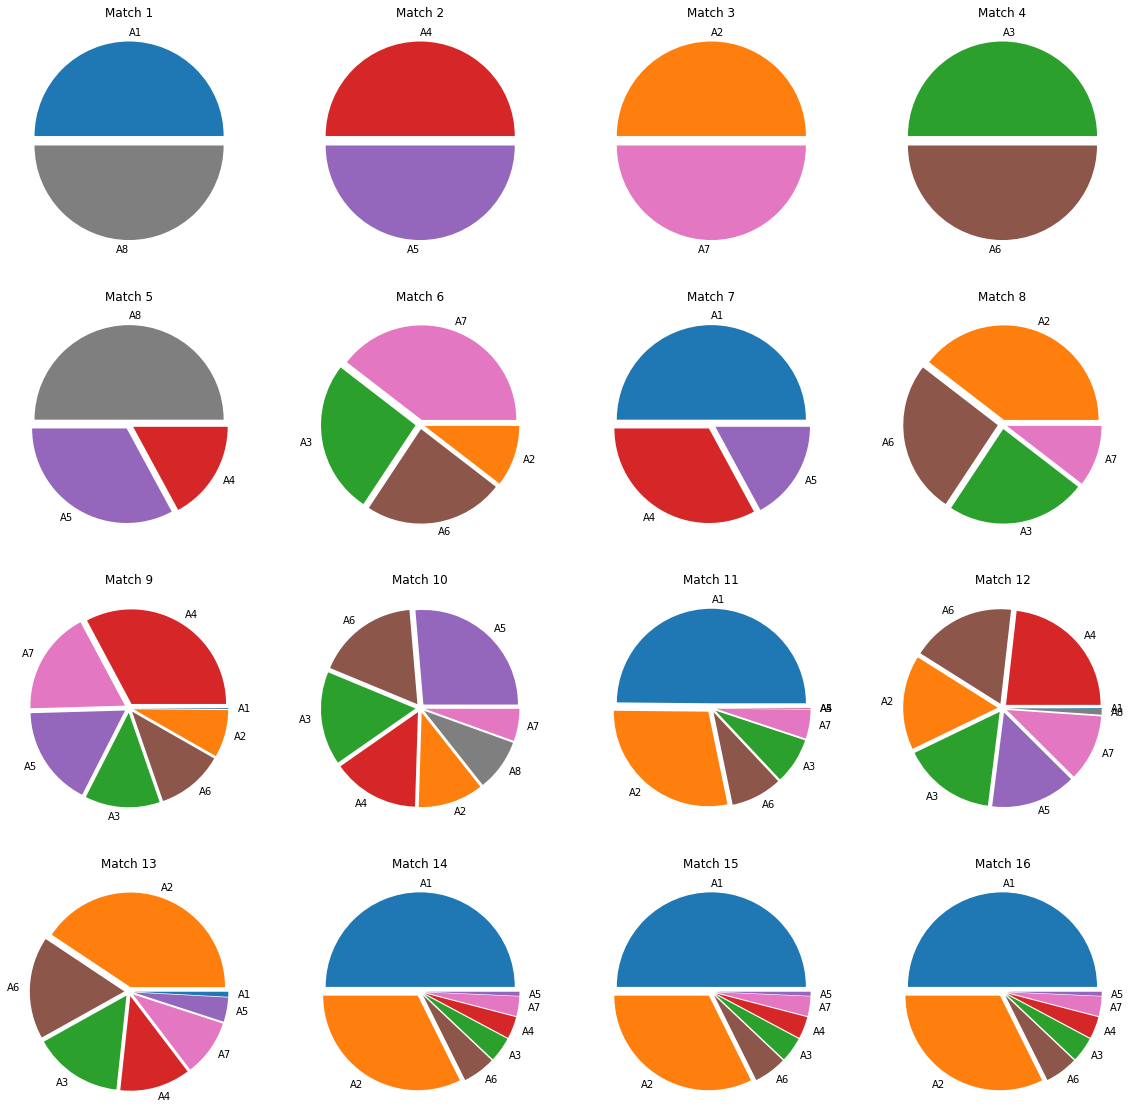

In [27]:
import matplotlib.pyplot as plt
import matplotlib
import json
import seaborn as sns
colors = sns.color_palette(n_colors=8) # ('Dark2', n_colors=8)
cmap = matplotlib.colors.ListedColormap(colors)
plt.rcParams["figure.figsize"] = (20, 20)

allianceLookup = dict([(str(alliances[k]),k) for k in alliances if k[0]=='A'] )
alliance_list = list(allianceLookup.values())


def makelabel(s):
    #l = json.loads(s.replace('\'','"'))
    #return ','.join(map(lambda x: x[3:], l))
    return allianceLookup[s]
    
fig,axs= plt.subplots(len(density)//4, 4)
for a,i in enumerate(density):
    ax = axs[a//4,a%4]
    k = list(sorted(density[i], reverse=True, key=lambda d: density[i][d]))
    v = [density[i][d] for d in k]
    labels=list(map(makelabel, k))
    color_indices = [alliance_list.index(a) for a in labels]
    colors = [cmap(index) for index in color_indices]
    ax.pie(v, labels=labels, colors=colors, explode=[0.05]*len(labels)) #wedgeprops = {'linewidth': 3, 'linecolor':'white'})
    ax.set_title(f'Match {i}')

In [ ]:
# swap alliance 1 and 6 third choice

alliances =  {
 'A1':   [7461, 2910,3681],
 'A2':  [488, 360, 4450],
 'A3':  [4911, 2412, 4512],
 'A4':  [5937, 1983, 3070],
 'A5':   [2976, 1899, 9023],
 'A6':   [492, 4682, 5827],
 'A7':   [1294, 948, 8248],
 'A8':   [9036, 949, 2928]
}

for k in alliances:
    alliances[k] = list(map(lambda x: f'frc{x}', alliances[k]))


overall = Counter()
for b in tqdm(range(1000)):
    w = runBracket()
    overall[w] += 1
        
for k in sorted(overall, key=lambda x: overall[x], reverse=True):
    print(k, overall[k])